In [96]:
!pip install langchain_community tiktoken langchain-groq langchain-mistralai rank_bm25 langchainhub chromadb langchain langgraph tavily-python langchain-huggingface arxiv wikipedia -q

In [97]:
import os
from google.colab import userdata
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_query import MultiQueryRetriever
from rank_bm25 import BM25Okapi
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_mistralai import ChatMistralAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

In [98]:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["MISTRAL_API_KEY"] = userdata.get('MISTRAL_API_KEY')

In [99]:
urls = ["https://medium.com/@muddassir10/machine-learning-based-price-estimation-a-practical-approach-7164b35d10fd"]

docs = [WebBaseLoader(url).load() for url in urls]
docs = [doc for doclist in docs for doc in doclist]

In [100]:
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=800, chunk_overlap=30
)
splitted_docs = splitter.split_documents(docs)

In [101]:
vector_db = Chroma.from_documents(
    documents=splitted_docs,
    collection_name='agentic-rag',
    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
)
base_retriever = vector_db.as_retriever()

In [102]:
retriever_llm = ChatGroq(model='llama-3.2-1b-preview')
retriever = MultiQueryRetriever.from_llm(
    retriever=base_retriever, llm=retriever_llm
)

In [103]:
def retrieve_docs(query):
  return retriever.invoke(query)

def rerank_docs(query,docs):
  tokenized_docs = [doc.page_content.split() for doc in docs]
  bm25 = BM25Okapi(tokenized_docs)
  scores = bm25.get_scores(query[0].split())
  ranked_docs = sorted(zip(docs,scores),key=lambda x:x[1],reverse=True)
  return ranked_docs

In [104]:
rag_llm = ChatMistralAI(model='mistral-large-latest',api_key=os.environ['MISTRAL_API_KEY'])
#rag_llm = ChatGroq(model='llama3-groq-8b-8192-tool-use-preview')

In [105]:
from langchain import hub
prompt_str = """
You are a helpful assistant specialized in question-answering tasks. Follow these instructions carefully:

1. Use the provided documents to answer the query.
2. If each of the documents is not relevant to the query, respond with exactly: "Documents Not Relevant".
3. If the documents are not relevant, invoke the tools(wikipedia_tool,arxiv_tool or tavily_tool) to generate an accurate and concise answer to the query.
4. Avoid hallucinating information. Base your answers only on the documents provided or on the tool's results.
5. Focus on providing only the major and most relevant details in your response.

Query: {query}
Documents: {docs}
Answer:
"""
prompt = ChatPromptTemplate.from_template(prompt_str)

In [106]:
rag_chain =  prompt |rag_llm| StrOutputParser()

In [107]:
query = "what are siamese networks"
rag_chain.invoke({'query':query,'docs':rerank_docs(query,retrieve_docs(query))[:3]})

'Documents Not Relevant'

In [108]:
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)

arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

tavily_tool = TavilySearchResults()

tools = [tavily_tool,wikipedia_tool,arxiv_tool]

In [109]:
query = "What is cosine similarity?"
llm_with_tools = rag_llm.bind_tools(tools=tools)
x = llm_with_tools.invoke(query)

In [110]:
x

AIMessage(content='Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used in positive space, where the outcome is neatly bounded in [0,1].\n\nThe cosine similarity of two vectors (A and B) is defined as:\n\n\\[ \\text{cosine\\_similarity}(A, B) = \\cos(\\theta) = \\frac{A \\cdot B}{\\|A\\| \\|B\\|} \\]\n\nwhere:\n- \\( A \\cdot B \\) is the dot product of \\( A \\) and \\( B \\)\n- \\( \\|A\\| \\) is the magnitude (or length) of vector \\( A \\)\n- \\( \\|B\\| \\) is the magnitude (or length) of vector \\( B \\)\n- \\( \\theta \\) is the angle between \\( A \\) and \\( B \\)\n\nCosine similarity is particularly useful in text analysis, where vectors represent the frequency of words or terms in documents. It helps in determining the similarity between documents, clustering similar docum

In [131]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages:Annotated[list,add_messages]

def retrieve(state: State):
  messages = state['messages']
  query = messages[0].content
  #docs = base_retriever.invoke(query)
  docs = retriever.invoke(query)
  ranked_docs = rerank_docs(query,docs)[:3]
  docs_str = " ".join([doc[0].page_content for doc in ranked_docs])

  return {'messages' : [{'content':"\n\n".join([doc[0].page_content for doc in ranked_docs]),'role':'system'}]}

def chat(state: State):
  messages = state['messages']
  query = messages[0].content
  docs = "\n".join([msg.content for msg in messages[:-1]])
  response = rag_chain.invoke({'query':query,'docs':docs})

  if response:
    res = llm_with_tools.invoke(query)
    return {'messages' : [{'content':"\n"+str(res)+"\n"+response,'role':'ai'}]}
  else:
    return {'messages' : [{'content':"\n"+response,'role':'ai'}]}

In [132]:
from langgraph.prebuilt import ToolNode,tools_condition

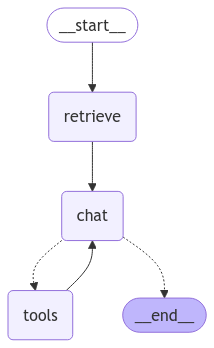

In [133]:
tool_node = ToolNode(tools=tools)
builder = StateGraph(State)
builder.add_edge(START,'retrieve')
builder.add_node('retrieve',retrieve)
builder.add_node('chat',chat)
builder.add_edge('retrieve','chat')
builder.add_node('tools',tool_node)
builder.add_conditional_edges('chat',tools_condition)
builder.add_edge('tools','chat')
graph = builder.compile()

from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [134]:
you = "what is bulking up?".capitalize()
events = graph.stream(
    {'messages': [('user',you)]},stream_mode='values'
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

What is bulking up?
================================ System Message ================================

ClassificationExcelGuideIntermediateProbabilityPythonPythonPyTorch 



Free Courses








    
                                            4.7
                                        


Generative AI - A Way of Life
Explore Generative AI for beginners: create text and images, use top AI tools, learn practical skills, and ethics.












    
                                            4.5
                                        


Getting Started with Large Language Models
Master Large Language Models (LLMs) with this course, offering clear guidance in NLP and model training made simple.












    
                                            4.6
                                        


Building LLM Applications using Prompt Engineering 
This free course guides you on building LLM apps, maste

In [138]:
x = graph.invoke({'messages':[{'content':"What is agentic AI",'role':'user'}]})

In [143]:
x['messages'][-1].content.split('\n')[-1]

'Agentic AI refers to artificial intelligence systems that are designed to act autonomously and proactively on behalf of users or other entities. These AI agents can perform tasks, make decisions, and interact with their environment without constant human oversight. They are often equipped with capabilities such as learning from experience, adapting to new situations, and communicating effectively to achieve their goals. Examples include virtual assistants, autonomous vehicles, and robotic systems used in various industries.'